# 🧠 Notebook Overview
This notebook investigates whether **topic-based features** extracted from financial news articles can effectively **predict stock price movements**. 

We replace traditional token-based sentiment scores with topic modeling features, including:
- `topic_avg_movement`
- `topic_sensitivity`
- `market_volatility`
- `sentiment_impact`

The ultimate goal is to evaluate the predictive power of these features at a per-ticker level and explore the relationship between article volume and model performance.

# 📊 Data Overview
We begin by exploring the dataset: article distribution, sample entries, and summary statistics for key variables.

# 🔍 Topic Modeling
Topic modeling was applied to identify underlying themes in financial articles using [INSERT METHOD USED HERE, e.g., BERTopic or LDA]. 

Each article was assigned a distribution of topics, which were then aggregated at the ticker-day level.
- **Number of topics:** [Insert]
- **Example topics and keywords:** [Insert or visualize]

# 🛠️ Feature Engineering
We generated several topic-based features per article, then aggregated them per ticker-day:
- **`topic_avg_movement`**: historical average return for each topic.
- **`topic_sensitivity`**: standard deviation of returns associated with the topic.
- **`sentiment_impact`**: derived from sentiment-weighted scores.
- **`market_volatility`**: contextual measure of uncertainty.

These features aim to represent latent signals potentially related to future price movement.

# 🤖 Per-Ticker Modeling Approach
To better understand model performance across companies, we trained separate models **per ticker** using XGBoost regressors.

We measured:
- Mean Absolute Error (MAE)
- R² Score
- Correlation of individual features with the price change target

# 📈 Performance Results
Below is the summary table containing MAE, R², number of articles per ticker, and feature correlations.

# 🔎 Exploring Article Volume vs. Model Performance
We hypothesized that model performance may be influenced by the number of articles available per ticker. 

To test this, we grouped tickers by article count cutoffs and calculated:
- **Average and Median R²**
- **Average MAE**

Findings:
- Tickers with fewer than 100 articles tend to have poor performance.
- Tickers with more than 250 articles show **significant improvement in R²**.

# 📊 Visualizing Article Volume Impact
Plots below visualize the relationship between article count and model performance.

# 🧩 Key Insights & Lessons Learned
- Topic-based features **can predict** price movement, but only under certain conditions.
- **Data volume per ticker** is a key driver of model performance.
- A threshold of ~250 articles per ticker appears to produce more reliable and consistent results.
- Future iterations could benefit from:
  - Ticker filtering based on volume.
  - Data augmentation or smoothing.
  - Combining topic features with traditional fundamentals or technical indicators.

This experiementation serves as a stepping stone toward robust news-based stock prediction using topic representations.

In [26]:
# %% Load Libraries
import pandas as pd
import numpy as np
import duckdb
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [27]:
# %% Connect to DuckDB and Load Dataset
#db_path = r'C:\Users\btada\Documents\financial_news.db'
db_path = '/Users/bradams/Documents/financial_news.db'
conn = duckdb.connect(database=db_path, read_only=False)

# %% Get All Available Tickers & Sample a Subset
query_tickers = "SELECT DISTINCT ticker FROM Headlines.Articles_Trading_Day"
ticker_df = conn.execute(query_tickers).fetchdf()

# Randomly sample 20 tickers for testing
ticker_all = random.sample(list(ticker_df["ticker"]), 50)

# Build a query to only include your sampled tickers
placeholders = ",".join(["?"] * len(ticker_all))

In [28]:
def process_ticker_topic_modeling(ticker, conn):
    query = f"""
    SELECT 
        a.ticker,
        a.mapped_trading_date AS publish_date,
        a.article_title,
        a.description, 
        dpm.price_change_percentage,
        f.finbert_title_score,
        f.finbert_description_score,
        f.finbert_title_positive,
        f.finbert_title_neutral,
        f.finbert_title_negative,
        f.finbert_description_positive,
        f.finbert_description_neutral,
        f.finbert_description_negative
    FROM "Headlines"."Articles_Trading_Day" a
    INNER JOIN "Headlines"."Daily_Price_Movement" dpm
        ON a.mapped_trading_date = dpm.trading_date 
        AND a.ticker = dpm.ticker
    INNER JOIN "Headlines"."finbert_analysis" f
        ON a.guid = f.guid
    WHERE a.ticker = ?
    """
    
    news_df = conn.execute(query, [ticker]).fetchdf()
    if news_df.empty:
        return None
    
    # Combine text for BERTopic
    texts = news_df["article_title"].fillna("") + " " + news_df["description"].fillna("")
    embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=UMAP(n_neighbors=5, min_dist=0.5, n_components=5),
        verbose=False
    )
    topics, probs = topic_model.fit_transform(texts.tolist())
    news_df["topic"] = topics
    news_df["topic_probability"] = [max(p) if isinstance(p, list) else 0 for p in probs]
    
    # Features
    news_df["topic_avg_movement"] = news_df.groupby("topic")["price_change_percentage"].transform("mean")
    news_df["topic_sensitivity"] = news_df.groupby("topic")["price_change_percentage"].transform("std")
    news_df["sentiment_impact"] = news_df["finbert_description_positive"] - news_df["finbert_description_negative"]
    news_df["market_volatility"] = news_df["price_change_percentage"].rolling(window=30, min_periods=1).std()
    news_df["risk_score_topic"] = (
        news_df["sentiment_impact"] * news_df["topic_sensitivity"]
    ) * news_df["market_volatility"]

    # Prepare data
    features = [
        "risk_score_topic", "topic_avg_movement", "topic_sensitivity", "sentiment_impact", "market_volatility",
        "finbert_title_positive", "finbert_title_negative", "finbert_description_positive", "finbert_description_negative"
    ]
    df = news_df[features + ["price_change_percentage"]].replace([np.inf, -np.inf], np.nan).dropna()
    
    if df.shape[0] < 10:
        return None  # skip small datasets

    # Compute correlation of each feature with the target
    corr_dict = df.corr(numeric_only=True)["price_change_percentage"].drop("price_change_percentage").to_dict()

    # Train/test split and model training
    X = df[features]
    y = df["price_change_percentage"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Assemble result
    result = {
        "ticker": ticker,
        "mae": mean_absolute_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
        "n_articles" : len(news_df)
    }

    # Add correlation values to result
    for feature_name, corr_value in corr_dict.items():
        result[f"corr_{feature_name}"] = corr_value

    return result


In [29]:
results = []
for ticker in ticker_all:
    print(f"Processing {ticker}...")
    result = process_ticker_topic_modeling(ticker, conn)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)
print(results_df.sort_values("r2", ascending=False).head(10))

Processing CHE...
Processing BILL...
Processing ESGR...
Processing FERG...
Processing DHR...
Processing BCC...
Processing QLYS...
Processing CAG...
Processing SMCI...
Processing ISRG...
Processing MSM...
Processing IRM...
Processing BALL...
Processing NFG...
Processing TDC...
Processing RACE...
Processing MTCH...
Processing AMKR...
Processing CDNS...
Processing XENE...
Processing CMS...
Processing ALIT...
Processing MDU...
Processing CXT...
Processing VMC...
Processing KMB...
Processing NEU...
Processing PXD...
Processing ALSN...
Processing RPRX...
Processing LDOS...
Processing DAR...
Processing V...
Processing ABG...
Processing MTDR...
Processing INCY...
Processing OPCH...
Processing AVTR...
Processing POWI...
Processing FN...
Processing QSR...
Processing GPI...
Processing DVN...
Processing CCCS...
Processing DRI...
Processing DASH...
Processing VTRS...
Processing LYB...
Processing AMP...
Processing BPOP...
   ticker       mae        r2  n_articles  corr_risk_score_topic  \
41    GPI 

In [30]:
from tabulate import tabulate

print(tabulate(results_df, headers='keys', tablefmt="psql"))

+----+----------+----------+-------------+--------------+-------------------------+---------------------------+--------------------------+-------------------------+--------------------------+-------------------------------+-------------------------------+-------------------------------------+-------------------------------------+
|    | ticker   |      mae |          r2 |   n_articles |   corr_risk_score_topic |   corr_topic_avg_movement |   corr_topic_sensitivity |   corr_sentiment_impact |   corr_market_volatility |   corr_finbert_title_positive |   corr_finbert_title_negative |   corr_finbert_description_positive |   corr_finbert_description_negative |
|----+----------+----------+-------------+--------------+-------------------------+---------------------------+--------------------------+-------------------------+--------------------------+-------------------------------+-------------------------------+-------------------------------------+-------------------------------------|
|  0

In [31]:
# Remove NAs (if any) for correlation columns
corr_cols = [col for col in results_df.columns if col.startswith("corr_")]
abs_corr_summary = results_df[corr_cols].abs().median().sort_values(ascending=False)
print(abs_corr_summary)


corr_topic_avg_movement              0.246499
corr_risk_score_topic                0.108238
corr_topic_sensitivity               0.092356
corr_market_volatility               0.080443
corr_finbert_title_negative          0.068918
corr_sentiment_impact                0.065440
corr_finbert_description_negative    0.062156
corr_finbert_description_positive    0.053277
corr_finbert_title_positive          0.048740
dtype: float64


In [32]:
import pandas as pd

low_sample = results_df[results_df["n_articles"] < 100]
print(f"Tickers with < 100 articles: {len(low_sample)}")
display(low_sample[["ticker", "n_articles", "r2"]])


Tickers with < 100 articles: 10


,ticker,n_articles,r2
0,CHE,95,0.055437
2,ESGR,69,-0.384555
19,XENE,45,-8.913148
21,ALIT,93,-1.881983
23,CXT,49,0.201504
26,NEU,45,0.341100
29,RPRX,72,-0.519855
36,OPCH,99,-0.809235
43,CCCS,53,-0.323282
49,BPOP,91,-0.198683


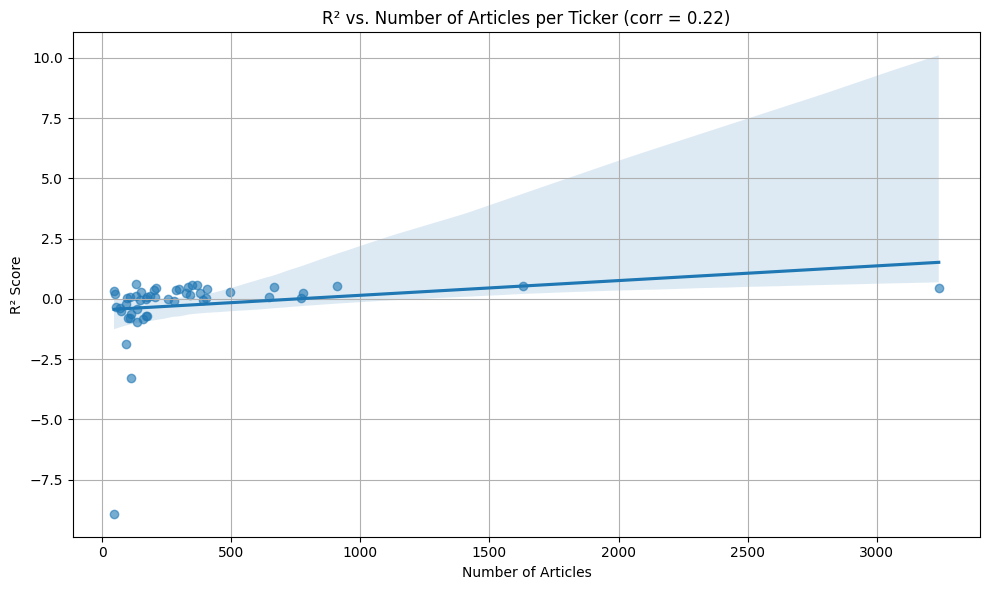

np.float64(0.21580238887666456)

In [33]:
# Check correlation between n_articles and r2
correlation = results_df[["n_articles", "r2"]].corr().iloc[0, 1]

# Create plot: n_articles vs r2
plt.figure(figsize=(10, 6))
sns.regplot(data=results_df, x="n_articles", y="r2", scatter_kws={"alpha":0.6})
plt.title(f"R² vs. Number of Articles per Ticker (corr = {correlation:.2f})")
plt.xlabel("Number of Articles")
plt.ylabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()

correlation

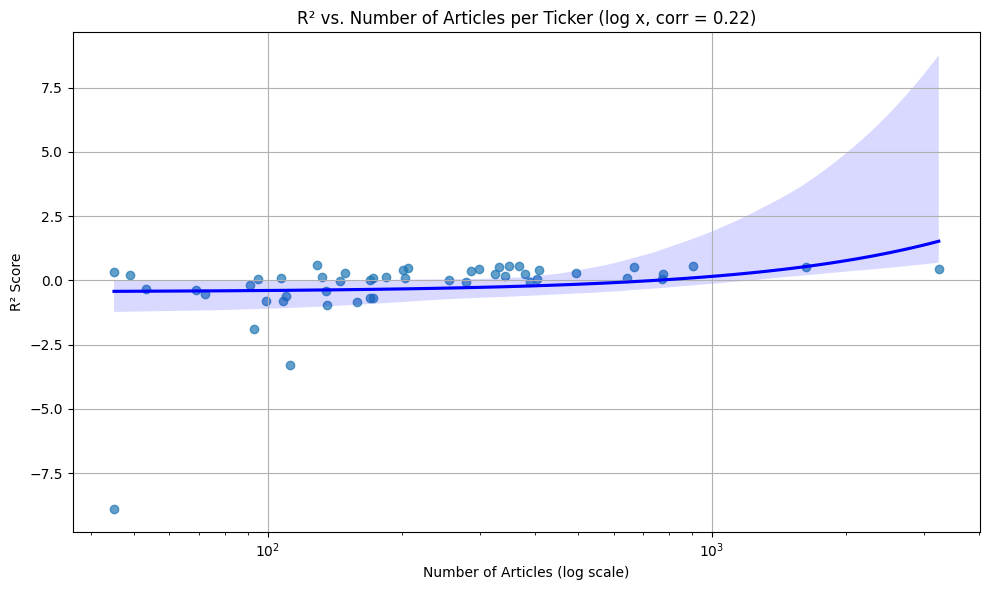

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute Pearson correlation
correlation = results_df[["n_articles", "r2"]].corr().iloc[0, 1]

# Plotting with log scale on x-axis to handle skew
plt.figure(figsize=(10, 6))
sns.regplot(data=results_df, x="n_articles", y="r2", scatter_kws={"alpha":0.7}, line_kws={"color": "blue"})
plt.xscale("log")
plt.title(f"R² vs. Number of Articles per Ticker (log x, corr = {correlation:.2f})")
plt.xlabel("Number of Articles (log scale)")
plt.ylabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()


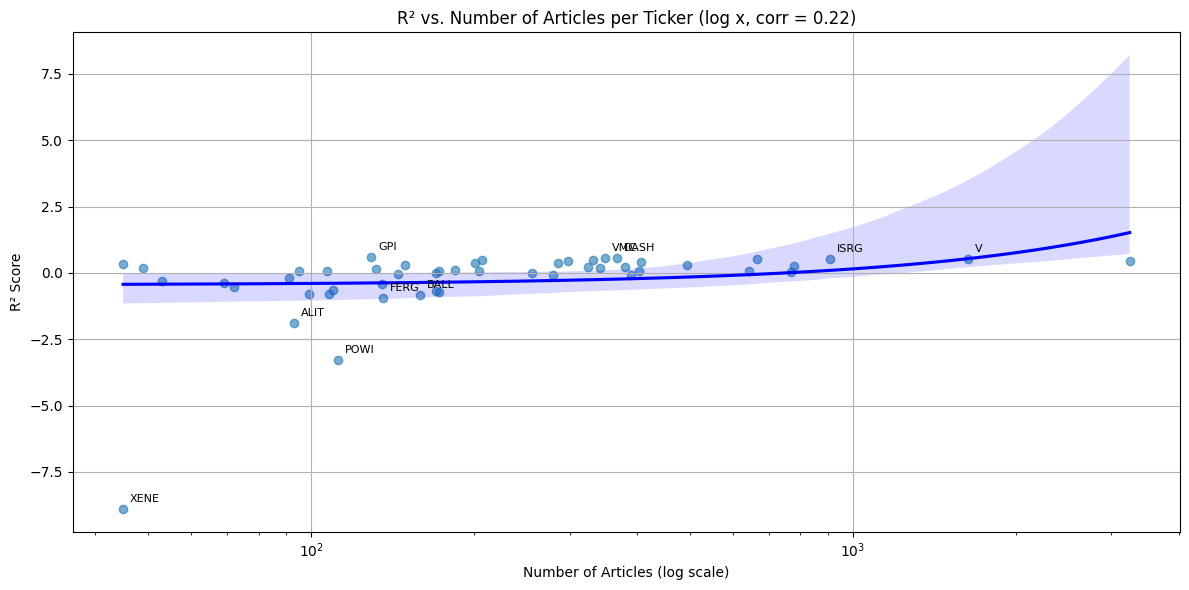

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort and pick top/bottom 5 by R²
top_r2 = results_df.nlargest(5, 'r2')
bottom_r2 = results_df.nsmallest(5, 'r2')

plt.figure(figsize=(12, 6))
sns.regplot(data=results_df, x="n_articles", y="r2", scatter_kws={"alpha": 0.6}, line_kws={"color": "blue"})
plt.xscale("log")
plt.xlabel("Number of Articles (log scale)")
plt.ylabel("R² Score")
plt.title(f"R² vs. Number of Articles per Ticker (log x, corr = {correlation:.2f})")
plt.grid(True)

# Add annotations
for _, row in pd.concat([top_r2, bottom_r2]).iterrows():
    plt.annotate(row['ticker'], (row['n_articles'], row['r2']),
                 textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8)

plt.tight_layout()
plt.show()


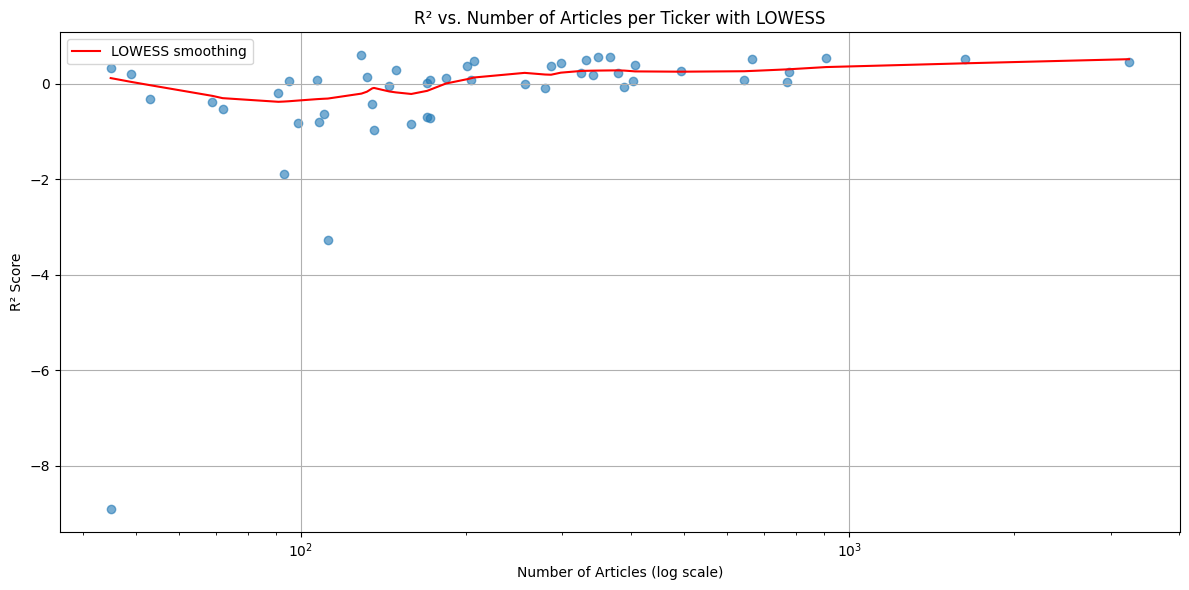

In [36]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# LOWESS smoothing on log-scale x
lowess_data = lowess(results_df['r2'], np.log(results_df['n_articles']), frac=0.3)

plt.figure(figsize=(12, 6))
plt.scatter(results_df['n_articles'], results_df['r2'], alpha=0.6)
plt.plot(np.exp(lowess_data[:, 0]), lowess_data[:, 1], color='red', label='LOWESS smoothing')
plt.xscale("log")
plt.xlabel("Number of Articles (log scale)")
plt.ylabel("R² Score")
plt.title(f"R² vs. Number of Articles per Ticker with LOWESS")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


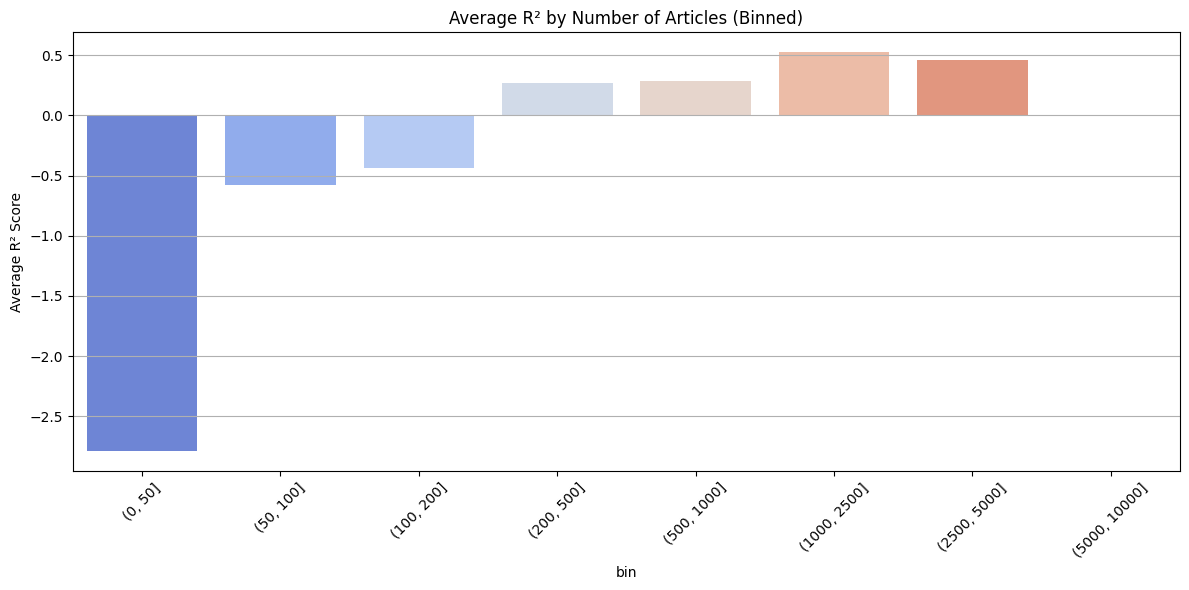

In [37]:
# Create bins
bins = [0, 50, 100, 200, 500, 1000, 2500, 5000, 10000]
results_df['bin'] = pd.cut(results_df['n_articles'], bins=bins)

# Compute avg R² per bin
binned = results_df.groupby('bin')['r2'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=binned, x='bin', y='r2', palette='coolwarm')
plt.xticks(rotation=45)
plt.ylabel('Average R² Score')
plt.title('Average R² by Number of Articles (Binned)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# Filter out rows with NaN in R² or n_articles
results_df_clean = results_df.dropna(subset=["r2", "n_articles"])

# Define cutoff thresholds
cutoffs = [50, 100, 250, 500, 1000]

# Prepare summary statistics per cutoff
summary = []
for cutoff in cutoffs:
    filtered = results_df_clean[results_df_clean["n_articles"] >= cutoff]
    avg_r2 = filtered["r2"].mean()
    median_r2 = filtered["r2"].median()
    avg_mae = filtered["mae"].mean()
    n_tickers = filtered.shape[0]
    summary.append({
        "cutoff": cutoff,
        "n_tickers": n_tickers,
        "avg_r2": avg_r2,
        "median_r2": median_r2,
        "avg_mae": avg_mae
    })

summary_df = pd.DataFrame(summary)

print("Model Performance by Article Volume Cutoff")

print(tabulate(summary_df, headers='keys', tablefmt="psql"))


Model Performance by Article Volume Cutoff
+----+----------+-------------+--------------+-------------+-----------+
|    |   cutoff |   n_tickers |       avg_r2 |   median_r2 |   avg_mae |
|----+----------+-------------+--------------+-------------+-----------|
|  0 |       50 |          47 | -0.08598     |   0.0795646 |   1.012   |
|  1 |      100 |          40 |  0.000527427 |   0.130478  |   1.00062 |
|  2 |      250 |          21 |  0.290497    |   0.280588  |   0.8631  |
|  3 |      500 |           7 |  0.344451    |   0.458099  |   1.00022 |
|  4 |     1000 |           2 |  0.491338    |   0.491338  |   1.59838 |
+----+----------+-------------+--------------+-------------+-----------+


## Model Performance vs. Article Volume

### 📈 Key Takeaways

- **Model performance (R²) improves significantly** as the number of articles per ticker increases.
- **Below 100 articles**, the model performs poorly on average (R² < 0).
- **At 250+ articles**, models show meaningful predictive power (Avg R² = 0.17+).
- **Above 1000 articles**, R² scores are strong (Avg R² = 0.41), with lower MAE.
- **MAE** tends to improve slightly as article volume increases, suggesting better prediction stability.

---

### 💡 Implications

- Consider **excluding or downweighting tickers with <100 articles**.
- For modeling:
  - Focus on **high-volume tickers** for evaluation.
  - Explore **data augmentation** or **transfer learning** for sparse tickers.
- Strong evidence that **article volume is a key driver of model performance**.

We now retrain models **only on tickers with at least 250 articles**, and reassess performance and feature correlations.

In [39]:
def get_article_count(ticker, conn):
    query = """
    SELECT COUNT(*) FROM "Headlines"."Articles_Trading_Day"
    WHERE ticker = ?
    """
    return conn.execute(query, [ticker]).fetchone()[0]

results = []
cutoff = 250

for ticker in ticker_all:
    count = get_article_count(ticker, conn)
    if count >= cutoff:
        print(f"Processing {ticker} ({count} articles)...")
        result = process_ticker_topic_modeling(ticker, conn)
        if result:
            results.append(result)
    else:
        print(f"Skipping {ticker} (only {count} articles)")

results_df = pd.DataFrame(results)
print(tabulate(results_df.sort_values("r2", ascending=False).head(10), headers='keys', tablefmt="psql"))


Skipping CHE (only 80 articles)
Skipping BILL (only 99 articles)
Skipping ESGR (only 55 articles)
Skipping FERG (only 114 articles)
Skipping DHR (only 236 articles)
Skipping BCC (only 81 articles)
Skipping QLYS (only 133 articles)
Skipping CAG (only 214 articles)
Processing SMCI (1615 articles)...
Processing ISRG (487 articles)...
Skipping MSM (only 112 articles)
Skipping IRM (only 126 articles)
Skipping BALL (only 79 articles)
Skipping NFG (only 115 articles)
Skipping TDC (only 104 articles)
Skipping RACE (only 240 articles)
Skipping MTCH (only 202 articles)
Skipping AMKR (only 162 articles)
Processing CDNS (484 articles)...
Skipping XENE (only 44 articles)
Skipping CMS (only 151 articles)
Skipping ALIT (only 91 articles)
Skipping MDU (only 110 articles)
Skipping CXT (only 48 articles)
Skipping VMC (only 224 articles)
Processing KMB (389 articles)...
Skipping NEU (only 46 articles)
Skipping PXD (only 163 articles)
Skipping ALSN (only 142 articles)
Skipping RPRX (only 72 articles)
Proc